# Diabetes
by Kenan Sooklall

Diabetes is a chronic (long-lasting) health condition that affects how your body turns food into energy.

Most of the food you eat is broken down into sugar (also called glucose) and released into your bloodstream. When your blood sugar goes up, it signals your pancreas to release insulin. Insulin acts like a key to let the blood sugar into your body’s cells for use as energy.

Source: [Centers for Disease Control and Preventation](https://www.cdc.gov/diabetes/basics/diabetes.html)

# Database Connection


Import the data you've selected into a SQL database of your choosing.  Connect your database to your Python environment.  Load your data to be analyzed using Python

Resources:

*   https://dev.mysql.com/doc/workbench/en/wb-admin-export-import-table.html 
*   https://medium.com/@tattwei46/how-to-use-python-with-mysql-79304bee8753
*   https://downloads.mysql.com/docs/connector-python-en.pdf
*   https://datatofish.com/how-to-connect-python-to-sql-server-using-pyodbc/



The dataset we are looking at is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

Acknowledgements
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

In [1]:
import pandas as pd
import numpy as np

import psycopg2 as pg
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
con = pg.connect(host="localhost", port = 5432, database="postgres", user="kenan", password='password')
df = pd.read_sql_query('select * from diabetes', con)
con.close()

In [3]:
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The data set contains 8 columns and 768 rows
- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
 - A blood sugar level less than 140 mg/dL (7.8 mmol/L) is normal.
 - A reading of more than 200 mg/dL (11.1 mmol/L) after two hours indicates diabetes.
 - A reading between 140 and 199 mg/dL (7.8 mmol/L and 11.0 mmol/L) indicates prediabetes.
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable ( 0 - 1)



source: https://www.cdc.gov/diabetes/basics/getting-tested.html

In [4]:
df.dtypes

pregnancies                   int64
glucose                       int64
bloodpressure                 int64
skinthickness                 int64
insulin                       int64
bmi                         float64
diabetespedigreefunction    float64
age                           int64
outcome                       int64
dtype: object

###  Exploratory Data Analysis

Very lucky to find a dataset with no missing values and no duplicated rows

In [5]:
print('Number of duplicates: {}'.format(df.duplicated().sum()))
df.isna().sum()

Number of duplicates: 0


pregnancies                 0
glucose                     0
bloodpressure               0
skinthickness               0
insulin                     0
bmi                         0
diabetespedigreefunction    0
age                         0
outcome                     0
dtype: int64

In [6]:
df.describe()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


we can see the data are all on very different scales, which is to be expected. An initial point of concern is  SkinThichkness of 0mm, however that could be more of a percision issue. Another column of concern is BMI, BloodPressure and Glucose, it can't be 0. The min age being greater than 0 is expected and all other values look normal

In [7]:
metrics = ['mean', 'median', 'std']
df.groupby(['outcome']).agg({"age": metrics,
                            "glucose": metrics,
                            "pregnancies": metrics,
                            "bmi": metrics,
                            "skinthickness": metrics})

age                       glucose                    \
              mean median        std        mean median        std   
outcome                                                              
0        31.190000   27.0  11.667655  109.980000  107.0  26.141200   
1        37.067164   36.0  10.968254  141.257463  140.0  31.939622   

        pregnancies                         bmi                   \
               mean median       std       mean median       std   
outcome                                                            
0          3.298000    2.0  3.017185  30.304200  30.05  7.689855   
1          4.865672    4.0  3.741239  35.142537  34.25  7.262967   

        skinthickness                    
                 mean median        std  
outcome                                  
0           19.664000   21.0  14.889947  
1           22.164179   27.0  17.679711

This dataset contains more negative cases than positive

<AxesSubplot:xlabel='outcome', ylabel='count'>

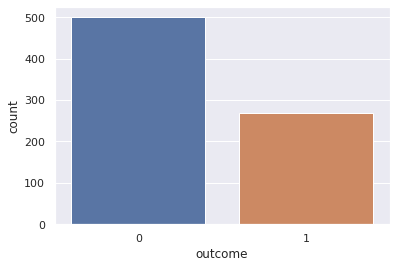

In [8]:
sns.countplot(x='outcome', data=df)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'pregnancies'),
  Text(1, 0, 'glucose'),
  Text(2, 0, 'bloodpressure'),
  Text(3, 0, 'skinthickness'),
  Text(4, 0, 'insulin'),
  Text(5, 0, 'bmi'),
  Text(6, 0, 'diabetespedigreefunction'),
  Text(7, 0, 'age'),
  Text(8, 0, 'outcome')])

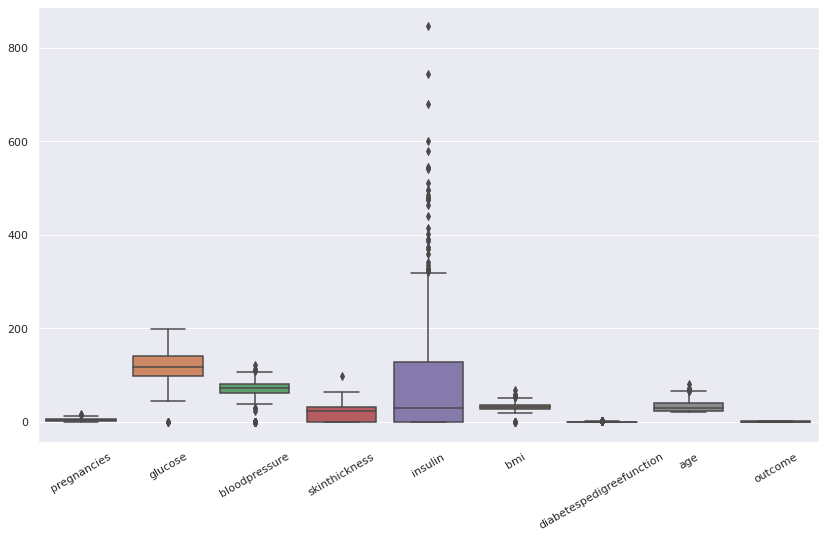

In [9]:
plt.figure(figsize=(14,8))
sns.boxplot(data=df)
plt.xticks(rotation = 30)

Most columns have a narrow band; however insulin has a lot of outliars

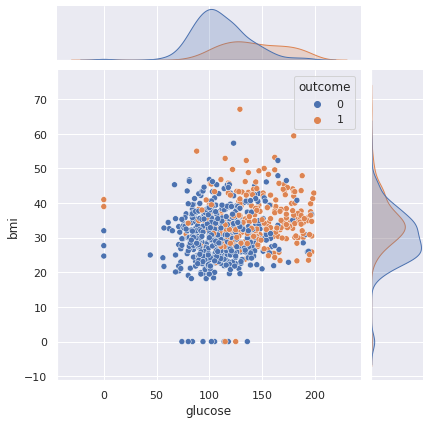

In [10]:
sns.jointplot(x='glucose' ,y='bmi' ,hue='outcome', data=df)

It looks like there is a seperation around Glucose levels of 100 for the Outcome

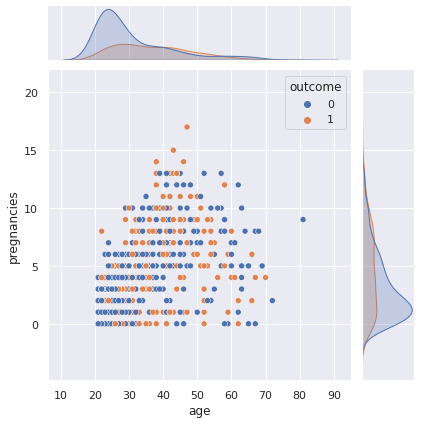

In [11]:
sns.jointplot(x='age' ,y='pregnancies' ,hue='outcome', data=df)

No correlation or pattern can be seen from this comparison between Pregnancies and Age

array([[<AxesSubplot:title={'center':'pregnancies'}>,
        <AxesSubplot:title={'center':'glucose'}>,
        <AxesSubplot:title={'center':'bloodpressure'}>],
       [<AxesSubplot:title={'center':'skinthickness'}>,
        <AxesSubplot:title={'center':'insulin'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'outcome'}>,
        <AxesSubplot:title={'center':'dpf_log'}>]], dtype=object)

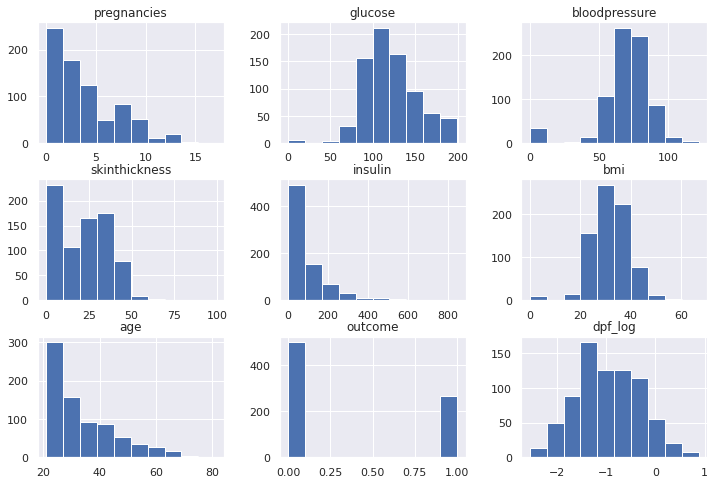

In [12]:
df.assign(dpf_log=np.log(df['diabetespedigreefunction'])).drop(['diabetespedigreefunction'], axis=1).hist(figsize=(12, 8))

Age and pregnancies are right skewed as expected, insulin is right skewed but I'm not sure why. All others are about normal. The target is categorical so the distribution is expected to show no distribution

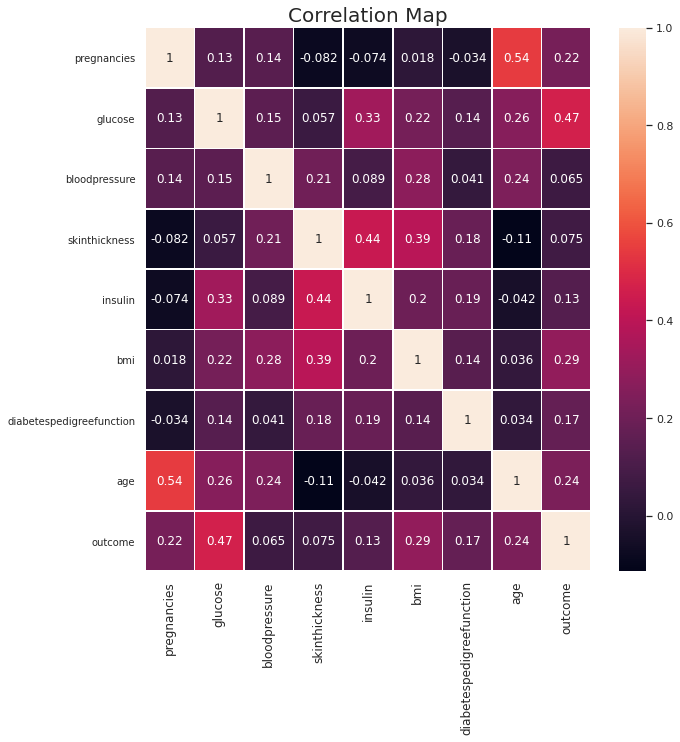

In [13]:
def correlated_map(dataframe, plot=False):
    corr = dataframe.corr()
    if plot:
        sns.set(rc={'figure.figsize': (10, 10)})
        sns.heatmap(corr, annot=True, linewidths=.7)
        plt.xticks(rotation=90, size=12)
        plt.yticks(size=10)
        plt.title('Correlation Map', size=20)
        plt.show()

correlated_map(df, plot=True)

From the heat map we see Glucose has the strongest correlation with the outcome. SkinThickness and BloodPressure have the lowest value, I understand why SkinThickness is low but I would think BloodPressure would be higher.

Based on the analysis above, rows with 0s for columns that can't intuitively be 0 will be dropped

In [14]:
non_zero_cols = ['glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi']
df = df[df[non_zero_cols].gt(0).sum(1).eq(len(non_zero_cols))]
df.describe()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Now every value is realistic

### Logistic Regression
This is a classification problem so LogisticRegression  is a good starting model

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate

In [16]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(df.drop(['outcome'], axis=1), df['outcome'])

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X_train)
Xt_std = scaler.transform(X_test)

I fine tune the model using sklearn grid search cross validation on 10 splits. The grid is the search space

In [18]:
model = LogisticRegression(random_state=42).fit(X, y_train)
stats = cross_validate(model, X, y_train, cv=10, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [19]:
y_pred = model.predict(Xt_std)
logistic_report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print(logistic_report)

              precision    recall  f1-score   support

    Negative       0.79      0.95      0.86        62
    Positive       0.87      0.56      0.68        36

    accuracy                           0.81        98
   macro avg       0.83      0.75      0.77        98
weighted avg       0.82      0.81      0.79        98



In [20]:
y_prob = model.predict_proba(Xt_std)[:, 1]
roc_auc_score(y_test, y_prob)

0.9350358422939069

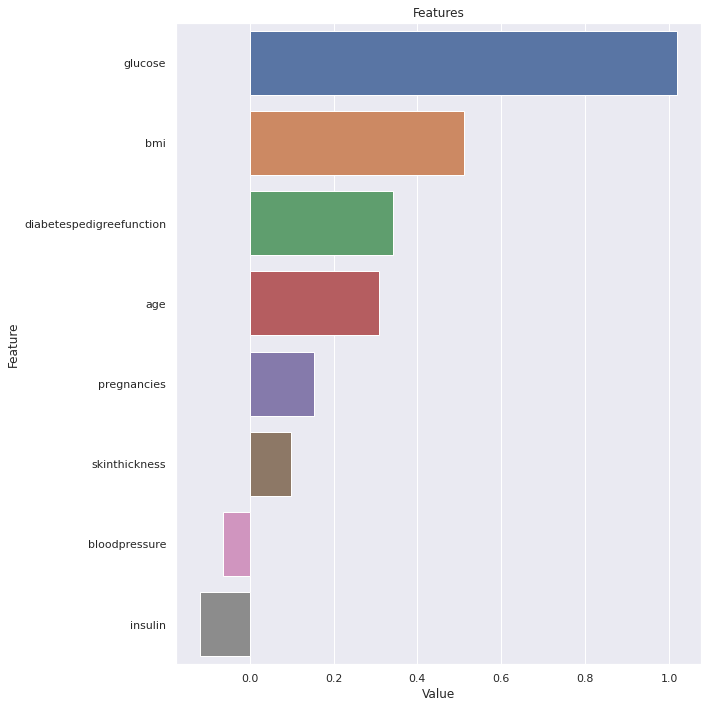

In [21]:
feature_imp = pd.DataFrame({'Value': model.coef_[0], 'Feature': X_train.columns})
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:8])
plt.title('Features')
plt.tight_layout()
plt.show()

As diabetes is known for it's correlation on Glucose, it's no suprised that Glucose is considered a, important feature.

### Multi-layer Perceptron

In [22]:
import torch
import torch.nn as nn

In [23]:
LEARNING_RATE = 1e-1
DENSE = 8
EPOCHS = 10000

In [24]:
torch.manual_seed(seed)
device = torch.device('cpu')

model = nn.Sequential(
    nn.Linear(X.shape[1], DENSE),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(DENSE),
    nn.Linear(DENSE, DENSE//2),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(DENSE//2),
    nn.Linear(DENSE//2, 1)
    )

model.float().to(device)

Sequential(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ReLU(inplace=True)
  (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=8, out_features=4, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=4, out_features=1, bias=True)
)

In [25]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1, steps_per_epoch=10, epochs=EPOCHS)

In [26]:
X_tensor = torch.tensor(X).float().to(device)
y_tensor = torch.tensor(y_train.values.reshape(y_train.shape[0], 1)).float().to(device)

In [27]:
best_acc = 0
best_model = None
history = []

for i in range(EPOCHS):
    y_pred = model(X_tensor)
    loss = criterion(y_pred.float(), y_tensor)
    acc = ((y_pred > 0.5).int() == y_tensor).sum() / X_tensor.shape[0]
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    history.append({'epoch': i, 'loss': loss.item(), 'acc': acc.item()})
    lr = optimizer.param_groups[0]['lr']
    
    if i % (EPOCHS/10) == 0:
        print('Epoch: {} \tloss: {:.3f} \tacc: {:.3f} \tlr: {:.4f}'.format(i, loss.item(), acc.item(), lr))
        
    if acc > best_acc:
        #print('[+] Saving best')
        best_acc = acc
        best_model = model

Epoch: 0 	loss: 0.731 	acc: 0.704 	lr: 0.0400
Epoch: 1000 	loss: 0.064 	acc: 0.959 	lr: 0.0426
Epoch: 2000 	loss: 0.051 	acc: 0.973 	lr: 0.0505
Epoch: 3000 	loss: 0.062 	acc: 0.966 	lr: 0.0635
Epoch: 4000 	loss: 0.049 	acc: 0.973 	lr: 0.0815
Epoch: 5000 	loss: 0.063 	acc: 0.963 	lr: 0.1043
Epoch: 6000 	loss: 0.050 	acc: 0.973 	lr: 0.1317
Epoch: 7000 	loss: 0.065 	acc: 0.969 	lr: 0.1633
Epoch: 8000 	loss: 0.057 	acc: 0.973 	lr: 0.1989
Epoch: 9000 	loss: 0.060 	acc: 0.973 	lr: 0.2379


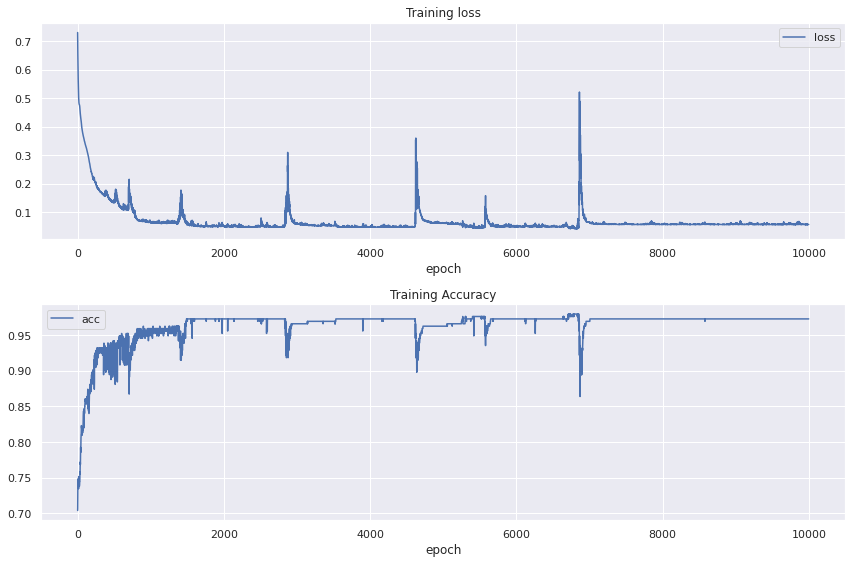

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
train_df = pd.DataFrame(history)
train_df.plot(x='epoch', y='loss', title='Training loss', ax=ax[0])
train_df.plot(x='epoch', y='acc', title='Training Accuracy', ax=ax[1])
plt.tight_layout()

In [29]:
y_prob = best_model(torch.tensor(Xt_std).float().to(device))
roc_auc_score(y_test, y_prob.detach().numpy())

0.7325268817204301

In [30]:
y_pred = (y_prob > 0.5).int().detach().numpy()
mlp_report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

### Comparing models

In [31]:
print('Logistic Regression')
print('-' * 60)
print(logistic_report + '\n')
print('Multi-layer Perceptron')
print('-' * 60)
print(mlp_report)


Logistic Regression
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.79      0.95      0.86        62
    Positive       0.87      0.56      0.68        36

    accuracy                           0.81        98
   macro avg       0.83      0.75      0.77        98
weighted avg       0.82      0.81      0.79        98


Multi-layer Perceptron
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.75      0.87      0.81        62
    Positive       0.69      0.50      0.58        36

    accuracy                           0.73        98
   macro avg       0.72      0.69      0.69        98
weighted avg       0.73      0.73      0.72        98



Over all Logistic regression provided a better model with a higher weighted avg F1-Score and all combinations of precision and recall. Both models suffer from similar problems of low precision and negative examples and  low recall on positive examples. The logistic regression also wins in the fact of how easy it is to train compare to the MLP. The MLP required a lot of tuning and computing power while logistic regression ran quickly.

# Conclusions 

In the United States, 88 million adults, more than 1 in 3 have prediabetes. What’s more, more than 84% of them don’t know they have it. The analysis done in this report is just a tiny fraction of the enormous work put into this field. The models trained here can do better with more data points and more features. However with the limited data the models created performed well.